In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

train = pd.read_csv("C:/nba_games_train.csv") # train 데이터셋
test = pd.read_csv("C:/nba_games_test.csv") # test 데이터셋

print(train.shape, test.shape)

(14283, 138) (1843, 138)


In [26]:
# 'max'로 끝나는 컬럼 선택

max_columns_train = [col for col in train if (col.endswith('_max') or col.endswith('_max_opp')) and col!='mp_max_opp.1']
max_columns_test = [col for col in test if (col.endswith('_max') or col.endswith('_max_opp')) and col!='mp_max_opp.1']

def remove_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df


In [27]:
import re

# '%'를 포함하는 컬럼들을 모으는 정규표현식
pattern = re.compile('.*%.*')

# max_columns 중에서 '%'를 포함하는 컬럼들을 선택
minmax_columns_train = [col for col in max_columns_train if pattern.match(col)]
robust_columns_train = train[max_columns_train].drop(columns=minmax_columns_train).columns.tolist()
minmax_columns_test = [col for col in max_columns_test if pattern.match(col)]
robust_columns_test = test[max_columns_test].drop(columns=minmax_columns_test).columns.tolist()

additional_columns = ['ftr', '3par']

minmax_columns_train.extend(additional_columns) # max_columns 중에서 '%','ftr', '3par'를 포함하는 컬럼들을 선택
minmax_columns_test.extend(additional_columns) # max_columns 중에서 '%','ftr', '3par'를 포함하는 컬럼들을 선택

other_columns_train = train.drop(columns=max_columns_train).columns.tolist()
other_columns_test = test.drop(columns=max_columns_test).columns.tolist()

# 중복을 제거하여 'ftr', '3par'을 포함하지 않는 컬럼들 선택
standard_columns_train = [col for col in other_columns_train if col not in additional_columns]
standard_columns_test = [col for col in other_columns_test if col not in additional_columns]

In [28]:
train2 = train.copy()
train3 = train.copy()
train4 = train.copy()
test2 = test.copy()
test3 = test.copy()
test4 = test.copy()

train2 = train[standard_columns_train]
train3 = train[minmax_columns_train]
train4 = train[robust_columns_train]
test2 = test[standard_columns_test]
test3 = test[minmax_columns_test]
test4 = test[robust_columns_test]

# 이상치 제거된 데이터프레임 생성
train3 = remove_outliers(train3, minmax_columns_train)
train4 = remove_outliers(train4, robust_columns_train)
test3 = remove_outliers(test3, minmax_columns_test)
test4 = remove_outliers(test4, robust_columns_test)

In [29]:
train5 = train2[standard_columns_train]
string_columns_train = train5.select_dtypes(include=['object']).columns
print(string_columns_train)

test5 = test2[standard_columns_test]
string_columns_test = test5.select_dtypes(include=['object']).columns
print(string_columns_test)

Index([], dtype='object')
Index([], dtype='object')


In [30]:
# 1. date 컬럼을 라벨 인코딩했는데, train에 대해 fit_transform으로 학습한 인코더 객체가 test에 대해
# 학습한 방식을 transform하여 적용할 경우 날짜가 상이하므로 오류 발생하여 실행 x
# -> gpt가 제시한 방법 중 train,test 병합해서 통째로 인코딩 후 분리 : 이건 애초에 정답 유출 문제 + new data 예측 불가 문제
# -> 기준 날짜로부터 일수 변환하는 방법으로 대체(이 방식을 채택함)
# -> (수정)이렇게 해놓고 나니 인코딩할 필요가 없어져서 문제가 해결됨
train5['date'] = pd.to_datetime(train5['date'])
test5['date'] = pd.to_datetime(test5['date'])
# object type이므로 날짜 형식으로 변경

print(train5['date'].dtype, test5['date'].dtype)

print("First date in 'date' column of train:", train5['date'].min())
print("First date in 'date' column of test:", test5['date'].min())

# test 데이터셋의 가장 이른 날짜인 2015-10-27을 시작의 기준으로 하자.
base_date = pd.to_datetime('2015-12-09')

# 날짜를 일수로 변환
train5['days_from_base'] = (train5['date'] - base_date).dt.days
test5['days_from_base'] = (test5['date'] - base_date).dt.days

KeyError: 'date'

In [8]:
# # Object 타입 변수 인코딩 - (1) 날짜 : 라벨 인코딩

# # date 열을 Label Encoding 적용
# label_encoder = LabelEncoder() # 인코더 객체가 train으로 학습&변환, test는 train에서 학습한 것 기반으로 변환(Don't fit_transform for test dataset)

# train5['date_encoded'] = label_encoder.fit_transform(train5['days_from_base'])
# train5 = train5.drop('days_from_base', axis=1)


# test5['date_encoded'] = label_encoder.transform(test5['days_from_base'])
# test5 = test5.drop('days_from_base', axis=1)

# # 주의 사항(ChatGPT)
# #테스트 데이터셋에 훈련 데이터셋에 없는 새로운 카테고리가 있는 경우, LabelEncoder는 해당 값을 처리하지 못하고 에러를 발생시킵니다. 이를 처리하려면 새로운 카테고리를 미리 예측하여 적절한 조치를 취해야 합니다.

train5 = train5.rename(columns={'days_from_base': 'date_gap'})
test5 = test5.rename(columns={'days_from_base': 'date_gap'})

In [24]:
# 2번째 고민 : 타깃 인코딩은 정답 레이블을 포함하기에 데이터 누수가 발생하게 됨. 이를 방지하고자
# k-fold로 교차 진행을 하는데, train은 어느 정도 예방이 된다고 하더라도 test dataset에서의 정답 컬럼을
# 건드는 것은 미친 짓임.
# -> train의 인코딩 결과를 test에 적용

# 훈련 데이터셋에 대한 타겟 인코딩
kf_train = KFold(n_splits=5, shuffle=True, random_state=42)
train5['team_encoded'] = 0
train5['team_opp_encoded'] = 0

for train_idx, val_idx in kf_train.split(train5):
    train_data = train5.iloc[train_idx]

    # 각 팀별 'won' 컬럼의 평균 계산 (훈련 데이터에서만)
    team_target_means = train_data.groupby('team')['won'].mean()

    # 'team'과 'team_opp' 컬럼을 인코딩된 값으로 대체
    train5.loc[val_idx, 'team_encoded'] = train5.iloc[val_idx]['team'].map(team_target_means)
    train5.loc[val_idx, 'team_opp_encoded'] = train5.iloc[val_idx]['team_opp'].map(team_target_means)

# 노이즈 추가
smoothing = 0.1
train5['team_encoded'] = train5['team_encoded'] * (1 - smoothing) + smoothing * np.random.randn(len(train5))
train5['team_opp_encoded'] = train5['team_opp_encoded'] * (1 - smoothing) + smoothing * np.random.randn(len(train5))

# 테스트 데이터셋에 대한 타겟 인코딩
kf_test = KFold(n_splits=5, shuffle=True, random_state=42)
test5['team_encoded'] = 0
test5['team_opp_encoded'] = 0

for train_idx, _ in kf_test.split(train5):  # 테스트 데이터셋에 대한 교차 검증은 훈련 데이터셋에 대해서만 수행
    train_data = train5.iloc[train_idx]

    # 각 팀별 'won' 컬럼의 평균 계산 (훈련 데이터에서만)
    team_target_means = train_data.groupby('team')['won'].mean()

    # 'team'과 'team_opp' 컬럼을 인코딩된 값으로 대체
    test5['team_encoded'] += test5['team'].map(team_target_means)
    test5['team_opp_encoded'] += test5['team_opp'].map(team_target_means)

# 교차 검증 인코딩 값의 평균 계산
test5['team_encoded'] /= kf_test.n_splits
test5['team_opp_encoded'] /= kf_test.n_splits

# 노이즈 추가
smoothing = 0.1
test5['team_encoded'] = test5['team_encoded'] * (1 - smoothing) + smoothing * np.random.randn(len(test5))
test5['team_opp_encoded'] = test5['team_opp_encoded'] * (1 - smoothing) + smoothing * np.random.randn(len(test5))

# 결과 출력

# 결과 출력
train5 = train5.drop(['team', 'team_opp'], axis=1)
print(train5.shape)

test5 = test5.drop(['team', 'team_opp'], axis=1)
print(test5.shape)




KeyError: 'team'

In [10]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
# RobustScaler 객체 생성
scaler = StandardScaler()
scaler2 = MinMaxScaler()
scaler3 = RobustScaler()
# max_columns에 대해 RobustScaler 적용
standard_scaled_train5 = scaler.fit_transform(train5)
minmax_scaled_train3 = scaler2.fit_transform(train3)
robust_scaled_train4 = scaler3.fit_transform(train4)

standard_scaled_test5 = scaler.transform(test5)
minmax_scaled_test3 = scaler2.transform(test3)
robust_scaled_test4 = scaler3.transform(test4)

In [11]:
standard_scaled_train5 = pd.DataFrame(standard_scaled_train5, columns=train5.columns)
minmax_scaled_train3 = pd.DataFrame(minmax_scaled_train3, columns=train3.columns)
robust_scaled_train4 = pd.DataFrame(robust_scaled_train4, columns=train4.columns)

standard_scaled_test5 = pd.DataFrame(standard_scaled_test5, columns=test5.columns)
minmax_scaled_test3 = pd.DataFrame(minmax_scaled_test3, columns=test3.columns)
robust_scaled_test4 = pd.DataFrame(robust_scaled_test4, columns=test4.columns)

In [12]:
# 진짜 중요한거
standard_scaled_train5['won'] = train5['won']
standard_scaled_test5['won'] = test5['won']

# 정답 컬럼, 특히 test 데이터셋의 label은 결측치 처리와 인코딩 정도를 제외하곤 절대 건드리지 말 것

In [13]:
# 각기 다른 스케일러로 조정된 3개 df 합치기
train_combined = pd.concat([robust_scaled_train4, minmax_scaled_train3, standard_scaled_train5], axis=1)
test_combined = pd.concat([robust_scaled_test4, minmax_scaled_test3, standard_scaled_test5], axis=1)

# null 값이 포함된 행을 삭제
train_cleaned = train_combined.dropna()
test_cleaned = test_combined.dropna()
print(train_cleaned.shape, test_cleaned.shape)

(14283, 137) (1843, 137)


In [14]:
# 승패 비율 계산
print(train_cleaned['won'].value_counts(normalize=True))
print(test_cleaned['won'].value_counts(normalize=True))

won
False    0.500035
True     0.499965
Name: proportion, dtype: float64
won
True     0.500271
False    0.499729
Name: proportion, dtype: float64


In [21]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 데이터 로드
train_file_path = 'C:/nba_games_train.csv'
test_file_path = 'C:/nba_games_test.csv'

train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

# 예측 변수(X)와 목표 변수(y) 분리
X_train = train_data.drop(columns=['won', 'Unnamed: 0'])
y_train = train_data['won']
X_test = test_data.drop(columns=['won', 'Unnamed: 0'])
y_test = test_data['won']

# 데이터셋을 학습과 테스트 셋으로 분리
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 엘라스틱넷 모델 학습
model = ElasticNet(alpha=1.0, l1_ratio=0.5)  # alpha는 λ1과 λ2의 합, l1_ratio는 λ1의 비율
model.fit(X_train, y_train)

# 모델 예측
y_pred = model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

# 테스트 데이터에 대한 예측 수행
y_test_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f"Test Mean Squared Error: {test_mse:.2f}")

Mean Squared Error: 0.25
Test Mean Squared Error: 0.25


Optimal alpha: 0.0033916609488328893
Optimal l1_ratio: 0.5
Selected Columns based on high regression coefficients:
['ortg', 'drtg_opp', 'ts%', 'tov_opp', 'fg%', 'pf_opp', 'total', 'ft', '3p%', 'pts', 'orb', 'trb%', '3pa_opp', 'ast%_max_opp', 'blk%', 'trb%_max_opp', 'stl', 'fta_max_opp', 'ft%', '3pa_max', 'fga_max_opp', '3par_max', 'tov_max', 'tov%_max_opp', 'fg_max', 'trb_max_opp', 'blk%_max_opp', 'team_encoded', 'ast_max', 'ts%_max_opp', 'ast_max_opp', 'blk%_max', 'trb_max', 'fg_max_opp', 'stl%_max', 'tov_max_opp', '3par_max_opp', 'fg%_max', '3pa_max_opp', 'fga_max', 'trb%_max', 'ft%_opp', 'team_opp_encoded', 'stl_opp', 'fta_max', 'blk%_opp', '3pa', 'total_opp', 'orb_opp', 'trb%_opp', '3p%_opp', 'ft_opp', 'pf', 'pts_opp', 'fg%_opp', 'tov', 'ts%_opp', 'drtg', 'ortg_opp']


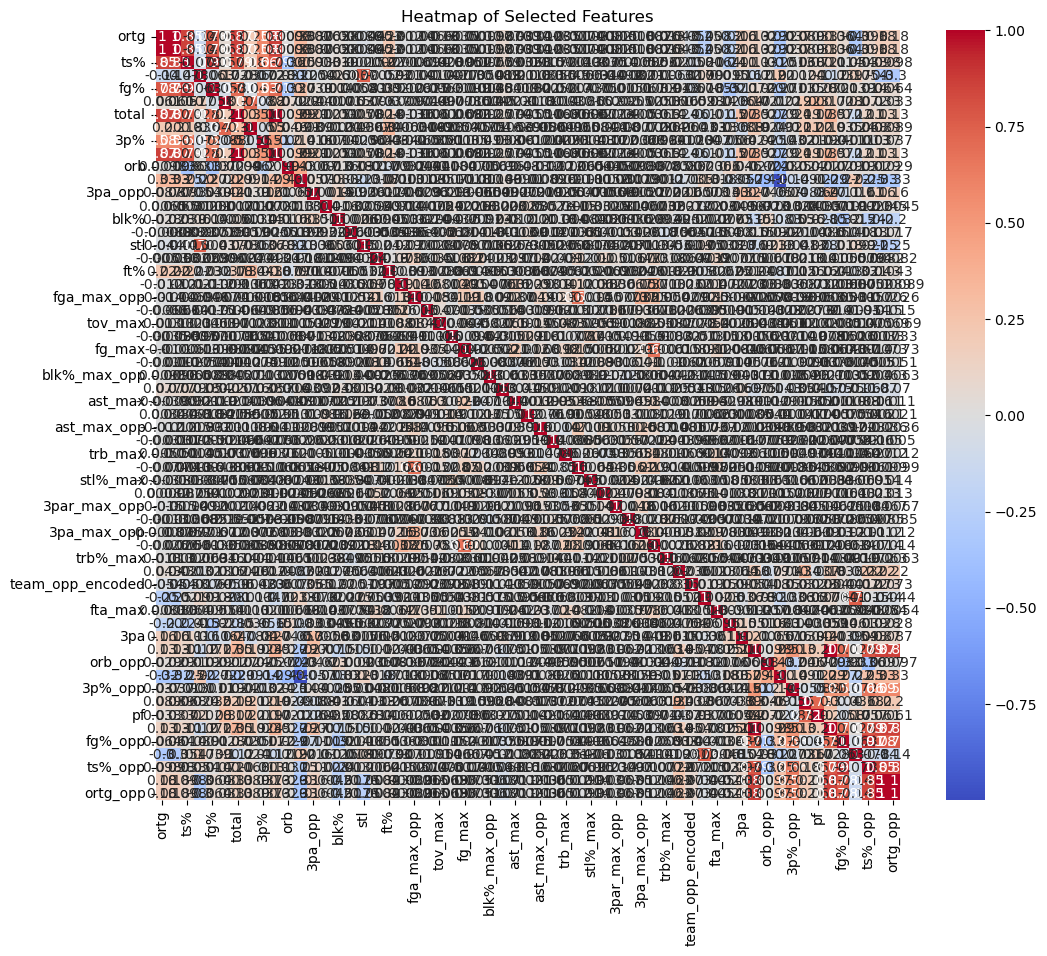

In [22]:
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 로드 및 전처리
train_file_path = 'C:/nba_games_train.csv'
test_file_path = 'C:/nba_games_test.csv'

train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

# 예측 변수(X)와 목표 변수(y) 분리
X_train = train_data.drop(columns=['won', 'Unnamed: 0'])
y_train = train_data['won']
X_test = test_data.drop(columns=['won', 'Unnamed: 0'])
y_test = test_data['won']

# 데이터 정규화
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 엘라스틱넷 교차 검증을 사용한 하이퍼파라미터 튜닝
elastic_cv = ElasticNetCV(cv=5, random_state=42)
elastic_cv.fit(X_train_scaled, y_train)

# 최적의 알파와 L1 비율 출력
optimal_alpha = elastic_cv.alpha_
optimal_l1_ratio = elastic_cv.l1_ratio_
print(f"Optimal alpha: {optimal_alpha}")
print(f"Optimal l1_ratio: {optimal_l1_ratio}")

# 변수 중요도 (회귀 계수)
coef = pd.Series(elastic_cv.coef_, index=X_train.columns)

# 회귀 계수가 높은 변수 선택
important_features = coef[coef.abs() > 0].sort_values(ascending=False)
selected_columns = important_features.index.tolist()

print("Selected Columns based on high regression coefficients:")
print(selected_columns)

# 선정된 columns의 히트맵 그리기
plt.figure(figsize=(12, 10))
sns.heatmap(train_data[selected_columns].corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap of Selected Features')
plt.show()


Optimal alpha: 0.0
Optimal l1_ratio: 0.5
Selected Columns based on high regression coefficients:
['ortg', 'drtg_opp', 'ts%', 'tov_opp', 'fg%', 'ft', 'pf_opp', 'total', '3p%', 'orb', 'pts', 'trb%', 'orb_opp', 'total_opp', '3p%_opp', 'trb%_opp', 'ft_opp', 'pf', 'pts_opp', 'tov', 'fg%_opp', 'ts%_opp', 'drtg', 'ortg_opp']


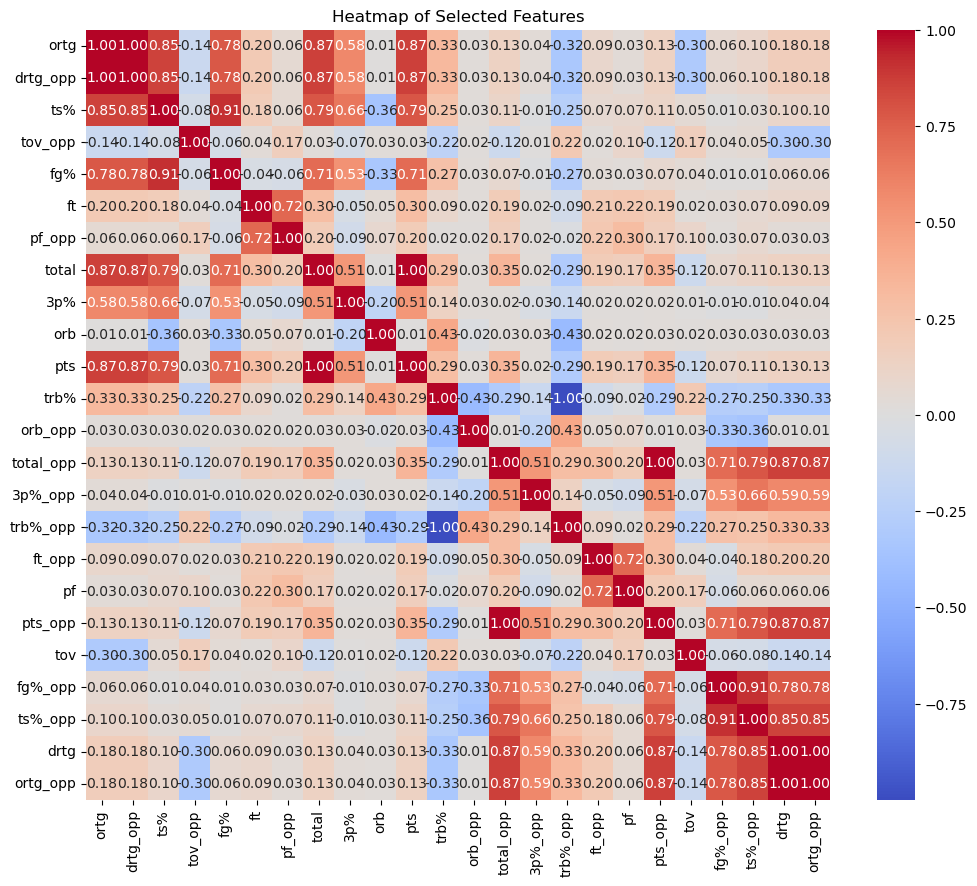

In [23]:
# 소수점 두 자리로만 출력하기 위해 포맷팅을 적용
optimal_alpha = round(elastic_cv.alpha_, 2)
optimal_l1_ratio = round(elastic_cv.l1_ratio_, 2)
print(f"Optimal alpha: {optimal_alpha}")
print(f"Optimal l1_ratio: {optimal_l1_ratio}")

# 변수 중요도 (회귀 계수) 소수점 두 자리로 표현
coef_rounded = coef.round(2)

# 회귀 계수가 높은 변수 선택
important_features_rounded = coef_rounded[coef_rounded.abs() > 0].sort_values(ascending=False)
selected_columns_rounded = important_features_rounded.index.tolist()

print("Selected Columns based on high regression coefficients:")
print(selected_columns_rounded)

# 선정된 columns의 히트맵 그리기
plt.figure(figsize=(12, 10))
sns.heatmap(train_data[selected_columns_rounded].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Heatmap of Selected Features')
plt.show()
